In this homework, we will use the Car price dataset like last week. Download it from here.

Or you can do it with wget:
```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```
We'll work with the MSRP variable, and we'll transform it to a classification task.

For the rest of the homework, you'll need to use only these columns:
* Make,
* Model,
* Year,
* Engine HP,
* Engine Cylinders,
* Transmission Type,
* Vehicle Style,
* highway MPG,
* city mpg
* MSRP

**Data preparation**

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average
* Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv


--2023-10-08 17:02:03--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1,4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1,41M  --.-KB/s    in 0,09s   

2023-10-08 17:02:03 (14,9 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [92]:
import pandas as pd
from typing import List
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import numpy as np
import matplotlib.pyplot as plt
import operator


In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
columns_to_use = ['Make', 'Model', 'Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style',
'highway MPG', 'city mpg', 'MSRP']

In [6]:
# Keep only the columns above
data = data[columns_to_use]

In [11]:
def rename_columns(l: List[str]):
    return [s.lower().replace(' ', '_') for s in l]

In [12]:
# Lowercase the column names and replace spaces with underscores
data.columns = rename_columns(data.columns)

In [14]:
# Fill the missing values with 0
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11845 non-null  float64
 4   engine_cylinders   11884 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   msrp               11914 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 930.9+ KB


In [15]:
data.fillna(0, inplace=True)

In [21]:
# Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average
data['above_average'] = (data.msrp > data.msrp.mean()).apply(int)

In [23]:
#  Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [27]:
train_full, test = train_test_split(data, test_size=0.2, random_state=1)

In [29]:
train, val = train_test_split(train_full, test_size=0.25, random_state=1)

**Question 1: ROC AUC feature importance**

ROC AUC could also be used to evaluate feature importance of numerical variables.
Let's do that

* For each numerical variable, use it as score and compute AUC with the above_average variable
* Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

* Which numerical variable (among the following 4) has the highest AUC?

 * engine_hp <--- this
 * engine_cylinders
 * highway_mpg
 * city_mpg

In [33]:
numerical_cols = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [37]:
res_dict = dict.fromkeys(numerical_cols)
for num_col in numerical_cols:
    _auc = roc_auc_score(y_score=train[num_col], y_true=train.above_average)
    if _auc < 0.5:
        _auc = roc_auc_score(y_score=-train[num_col], y_true=train.above_average)        
    res_dict[num_col] = _auc

In [38]:
res_dict

{'engine_hp': 0.9171031265539011,
 'engine_cylinders': 0.766116490165669,
 'highway_mpg': 0.6330587871772013,
 'city_mpg': 0.6734244643245233}

**Question 2: Training the model**
* Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```
* What's the AUC of this model on the validation dataset? (round to 3 digits)

 * 0.678
 * 0.779
 * 0.878
 * 0.979 <--- this

In [41]:
log_reg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
dv = DictVectorizer()

In [43]:
X_train = train.drop(columns=['msrp', 'above_average'])

In [52]:
X_val = val.drop(columns=['msrp', 'above_average'])

In [53]:
y_val = val['above_average']

In [44]:
y_train = train['above_average']

In [48]:
dict_train = dv.fit_transform(X_train.to_dict(orient='records'))

In [49]:
log_reg.fit(dict_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [50]:
y_train_predicted = log_reg.predict(dict_train)

In [55]:
y_val_predicted = log_reg.predict(dv.transform(X_val.to_dict(orient='records')))
y_val_score = log_reg.predict_proba(dv.transform(X_val.to_dict(orient='records')))

In [64]:
print(f'ROC AUC score is {roc_auc_score(y_val, y_val_score[:,1])}')

ROC AUC score is 0.9765698650295463


**Question 3: Precision and Recall**

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them
* At which threshold precision and recall curves intersect?

 * 0.28
 * 0.48 <--- this
 * 0.68
 * 0.88

In [71]:
steps = np.arange(0, 1.01, 0.01)

In [74]:
precision = []
recall = []

for step in steps:
    y_predicted = (y_val_score[:, 1]>step).astype(int)
    precision.append(precision_score(y_true=y_val, y_pred=y_predicted))
    recall.append(recall_score(y_true=y_val, y_pred=y_predicted))

/home/taras/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Value')

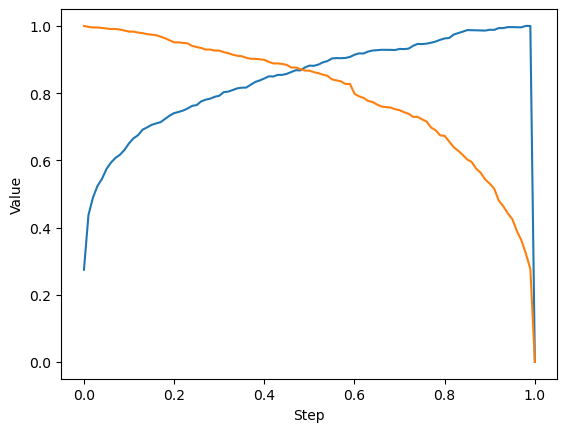

In [79]:
plt.plot(steps, precision, label='Precision')
plt.plot(steps, recall, label='Recall')
plt.xlabel('Step')
plt.ylabel('Value')

**Question 4: F1 score**

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
$$F1 = \frac{P\cdot Q}{P+Q}$$
 
Where $P$ is precision and $Q$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?
* 0.12
* 0.32
* 0.52 <---this
* 0.72

In [82]:
f1_vals = dict.fromkeys(steps)
for step in steps:
    y_predicted = (y_val_score[:, 1]>step).astype(int)
    f1_vals[step]=f1_score(y_true=y_val, y_pred=y_predicted)

In [90]:
print(f'The key for max {max(f1_vals.items(), key=operator.itemgetter(1))[0]}')

The key for max 0.5


In [89]:
f1_vals[0.52], f1_vals[0.12], f1_vals[0.32], f1_vals[0.72]

(0.8719937936384793, 0.7992518703241895, 0.8579586009992862, 0.824232081911263)

**Question 5: 5-Fold CV**
* Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
```python
KFold(n_splits=5, shuffle=True, random_state=1)
```
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation
* How large is standard devidation of the scores across different folds?

 * 0.003 <--this
 * 0.030
 * 0.090
 * 0.140

In [93]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [100]:
auc_score  = []
for train_index, test_index in kfold.split(train_full):
    log_reg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    
    X_train = train_full.iloc[train_index].drop(columns=['msrp', 'above_average'])
    y_train = train_full.iloc[train_index]['above_average']
    
    X_test = train_full.iloc[test_index].drop(columns=['msrp', 'above_average'])
    y_test = train_full.iloc[test_index]['above_average']
    
    dv = DictVectorizer()
    
    log_reg.fit(dv.fit_transform(X_train.to_dict(orient='records')), y_train)
    
    auc_score.append(roc_auc_score(y_score=log_reg.predict_proba(dv.transform(X_test.to_dict(orient='records')))[:,1],y_true= y_test))

In [104]:
print(f'Standard deviation {round(np.std(auc_score), 3)}')

Standard deviation 0.003


**Question 6: Hyperparemeter Tuning**
* Now let's use 5-Fold cross-validation to find the best parameter C
* Iterate over the following C values: [0.01, 0.1, 0.5, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: 
```python
LogisticRegression(solver='liblinear', C=C, max_iter=1000)
```
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
* Which C leads to the best mean score?

 * 0.01
 * 0.1
 * 0.5
 * 10 <--- this
* If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [111]:
c_values = [0.01, 0.1, 0.5, 10]

res = dict.fromkeys(c_values)
res_std = dict.fromkeys(c_values)

for _c in c_values:
    m = []
    for train_index, test_index in kfold.split(train_full):
        log_reg = LogisticRegression(solver='liblinear', C=_c, max_iter=1000)

        X_train = train_full.iloc[train_index].drop(columns=['msrp', 'above_average'])
        y_train = train_full.iloc[train_index]['above_average']

        X_test = train_full.iloc[test_index].drop(columns=['msrp', 'above_average'])
        y_test = train_full.iloc[test_index]['above_average']

        dv = DictVectorizer()

        log_reg.fit(dv.fit_transform(X_train.to_dict(orient='records')), y_train)

        m.append(roc_auc_score(y_score=log_reg.predict_proba(dv.transform(X_test.to_dict(orient='records')))[:,1],
                               y_true= y_test))
    res[_c] = round(np.mean(m), 3)        
    res_std[_c] = round(np.std(m), 3)

In [112]:
res

{0.01: 0.952, 0.1: 0.972, 0.5: 0.979, 10: 0.981}

In [113]:
res_std

{0.01: 0.002, 0.1: 0.002, 0.5: 0.001, 10: 0.003}